# HPRT P00492 EXTRA ANALYSIS

## Libraries, functions and dictionaries

In [35]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re
#import ptitprince as pt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [36]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [37]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [38]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [39]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [40]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [41]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [42]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [43]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [44]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [45]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [46]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [47]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [48]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [49]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [50]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [51]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [52]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [53]:
def print_chimera_x_attribute_file_SBI(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            if attribute_check[i]==1.0:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,1))
            else:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,0))
    file.close()

In [54]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [55]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [56]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [57]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

### setup ML functions

In [58]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [59]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [60]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [61]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [62]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [63]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [64]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [65]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [66]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

## Load trained model

In [67]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [34]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load dataset

### P00492

In [70]:
P00492_WT_sequence="MATRSPGVVISDDEPGYDLDLFCIPNHYAEDLERVFIPHGLIMDRTERLARDVMKEMGGHHIVALCVLKGGYKFFADLLDYIKALNRNSDRSIPMTVDFIRLKSYCNDQSTGDIKVIGGDDLSTLTGKNVLIVEDIIDTGKTMQTLLSLVRQYNPKMVKVASLLVKRTPRSVGYKPDFVGFEIPDKFVVGYALDYNEYFRDLNHVCVISETGKAKYKA"
P00492_WT_seq_rose="----SPGVVISDDEPGYDLDLFCIPNHYAEDLERVFIPHGLIMDRTERLARDVMKEMGGHHIVALCVLKGGYKFFADLLDYIKALNRNSDRSIPMTVDFIRLK----------IKVIGGDDLSTLTGKNVLIVEDIIDTGKTMQTLLSLVRQYNPKMVKVASLLVKRT-----YKPDFVGFEIPDKFVVGYALDYNEYFRDLNHVCVISETGKAKYKA"

In [71]:
count=0
for i in range(len(P00492_WT_sequence)):
    if P00492_WT_seq_rose[i]==P00492_WT_sequence[i]:
        count+=1
print(len(P00492_WT_sequence),count/len(P00492_WT_sequence))

218 0.9128440366972477


#### P00492 active site

In [72]:
P00492_db_positions=[138,200,187,134,135]

#### Co-evolution

In [74]:
P00492_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P00492.txt',P00492_WT_sequence)
P00492_GEMME=remove_WT_score(P00492_GEMME,P00492_WT_sequence)

In [75]:
P00492_GEMME_mean=position_mean(P00492_GEMME)

####  Rosetta ddG

In [78]:
P00492_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P00492.txt",P00492_WT_seq_rose,0)
P00492_rosetta_ddg=remove_WT_score(P00492_rosetta_ddg,P00492_WT_sequence)

In [79]:
P00492_rosetta_ddg_norm=normalize_cutoff(P00492_rosetta_ddg,0.0,5.0)

In [80]:
P00492_rosetta_ddg_mean=position_mean(P00492_rosetta_ddg_norm)

#### CAVITY

In [81]:
P00492_cavity_ddg=load_data_V2('../score_RaSP/prism_cavity_P00492_A.txt',P00492_WT_sequence,column_score=2)

In [82]:
P00492_cavity_ddg_norm=normalize_cutoff(P00492_cavity_ddg,0.0,5.0)

In [83]:
P00492_cavity_ddg_mean=position_mean(P00492_cavity_ddg_norm)

(-0.1, 5.1)

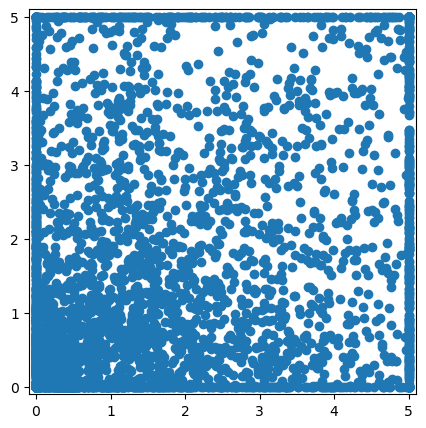

In [84]:
P00492fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(P00492_rosetta_ddg_norm,P00492_cavity_ddg_norm)
ax.set_xlim(-0.1,5.1)
ax.set_ylim(-0.1,5.1)

#### Hydrophobicity

In [85]:
P00492_hydrophobicity_mut=np.empty((len(P00492_WT_sequence),20),dtype=float)
P00492_hydrophobicity_mut[:]=np.nan

In [86]:
for i in range(len(P00492_WT_sequence)):
    for j in range(20):
        P00492_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [88]:
P00492_wcn=WCN('../pdbs/P00492_1z7g.pdb','ca',P00492_WT_sequence)

SER5


#### Neigbor scores

In [89]:
P00492_rosetta_neigbor_scores=neighbor_scores(P00492_rosetta_ddg_mean,1)

P00492_GEMME_neigbor_scores=neighbor_scores(P00492_GEMME_mean,1)


P00492_cavity_neigbor_scores=neighbor_scores(P00492_cavity_ddg_mean,1)


### P00492 Analysis

In [90]:
P00492_X,P00492_map=features_validation([P00492_GEMME,P00492_rosetta_ddg_norm, P00492_GEMME_mean, P00492_rosetta_ddg_mean, P00492_hydrophobicity_mut,P00492_GEMME_neigbor_scores,P00492_rosetta_neigbor_scores,P00492_wcn],P00492_WT_sequence)

In [91]:
len(P00492_WT_sequence)

218

In [92]:
prediction=cat.predict(P00492_X)

In [93]:
P00492_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P00492_map,P00492_WT_sequence,0.50)

In [177]:
print(index_positive_SBI(P00492_3mode_prediction,percentage[:,0],P00492_db_positions),P00492_db_positions)

([133, 134, 137], []) [138, 200, 187, 134, 135]


In [178]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

474


In [179]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

1046


In [180]:
count=0
for i,n in enumerate(P00492_3mode_prediction):
    if n==1:
        print(P00492_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

D13, G40, R45, L68, G70, I114, G127, K128, E134, D135, I136, D138, T139, G140, T142, K166, D194, H204, V207, 19


In [258]:
count=0
for i,n in enumerate(P00492_3mode_prediction):
    if n==0:
        print(P00492_WT_sequence[i],i+1,", ",sep="",end="")  
        count+=1
print(count)

S5, P6, G7, V8, V9, S11, D12, E14, P15, Y17, D18, D20, L21, C23, I24, P25, N26, H27, A29, E30, E33, R34, P38, H39, L41, M43, D44, E47, R48, R51, D52, M54, K55, E56, G58, G59, H60, H61, V63, K69, Y72, K73, F75, A76, D77, L79, D80, Y81, K83, A84, L85, N86, R87, N88, S89, D90, R91, S92, I93, P94, T96, V97, D98, R101, K103, K115, I117, G119, D120, D121, L122, S123, T124, T126, I137, K141, Q144, T145, L147, S148, L149, R151, Q152, Y153, N154, K156, M157, K159, V165, R167, T168, Y174, K175, D177, V179, E182, P184, D185, K186, Y195, N196, E197, Y198, D201, N203, S209, E210, T211, K213, A214, K215, K217, A218, 113


In [501]:
for i,n in enumerate(P00492_3mode_prediction):
    if n==1:
        print("/A:",i," ",sep="",end="")

/A:12 /A:39 /A:44 /A:67 /A:69 /A:113 /A:126 /A:127 /A:133 /A:134 /A:135 /A:137 /A:138 /A:139 /A:141 /A:165 /A:193 /A:203 /A:206 

In [502]:
print(P00492_rosetta_ddg[200])

[2.43114943 2.91977011        nan 0.3362069  2.06689655 3.07701149
 2.04137931 2.63402299 2.27       1.77402299 2.25666667 1.96344828
 4.21103448 1.43068966 2.34551724 2.35965517 2.04954023 2.08344828
 1.64494253 2.09      ]


In [503]:
print(P00492_rosetta_ddg[187])

[ 2.83873563  2.31413793  4.74574713  4.65287356  1.48517241  5.03977011
  2.65689655  0.10609195  5.62195402 -0.17471264  1.61816092  2.44712644
  6.01597701  3.88862069  5.82597701  3.37781609  1.55321839         nan
  2.35827586  2.07804598]


In [183]:
x_e=[]
for i in [ i for i,n in enumerate(P00492_3mode_prediction)]:   
        x_e.append(variants_extract(prediction,P00492_map,i))
x_e=np.array(x_e)

In [95]:
RHP_list=pd.read_csv("../score_maves/P00492_list_RPH.txt")
RHP_local_list=['I10S','N26T','R51Q','H60R','L68R','G70E','G70R','Y72C','L78Q','F99V','V133M','D135G','D135V','L163S','R167T','D194E','R200T']

In [523]:
#variants_extract(prediction,P00492_map,i)
for i in RHP_local_list:
    #print(i, P00492_3mode_prediction[int(i[1:-1])-1], variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1])
    if variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==1.0:     
        label_v='SBIv'
    elif variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==0.0:
        label_v='WT-like'
    elif variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==2.0:
        label_v='total-loss'
    else:
        label_v='yellow'        
    if P00492_3mode_prediction[int(i[1:-1])-1] ==1.0:   
        label_r='SBIr'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==0.0:   
        label_r='WT-like'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==2.0:   
        label_r='total-loss'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==3.0:
        label_r="yellow"
    else:
        label_r="mixed"
        
    print(i,label_v,label_r,P00492_rosetta_ddg[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1],P00492_rosetta_ddg_mean[int(i[1:-1])-1],P00492_GEMME[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1],P00492_GEMME_mean[int(i[1:-1])-1], sep=", ")

I10S, total-loss, total-loss, 4.034712643678172, 2.4748154869933536, -2.86634327619012, -2.4836717103723296
N26T, WT-like, WT-like, -0.0931034482758558, 0.11197822141560106, -0.293535994433699, -0.5594833775863804
R51Q, WT-like, WT-like, 0.7252873563218066, 0.8143436176648167, -0.292891481432503, -0.5811397077589597
H60R, WT-like, WT-like, 1.3755172413792434, 1.4950514216575375, -0.465151837339045, -0.641525322422089
L68R, SBIv, SBIr, 1.2582758620689267, 1.197217180883231, -5.98060721583796, -4.611775533997554
G70E, SBIv, SBIr, 1.3278160919540123, 2.452534785238946, -4.55073198930683, -5.348825607697777
G70R, SBIv, SBIr, 1.275287356321842, 2.452534785238946, -4.93977587951333, -5.348825607697777
Y72C, WT-like, WT-like, 1.5942528735632582, 1.2347610405323928, -1.92410097654775, -2.1222046889658577
L78Q, total-loss, total-loss, 3.0652873563218006, 3.5138415003024597, -5.02876324226816, -4.806284657727314
F99V, total-loss, total-loss, 4.42919540229881, 3.486805807622475, -3.0331068632693,

## RaSP prediction
### load model

In [68]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [69]:
cat.load_model('../catboost_model/cat_gemme_af_cavity_13apr23.cbm')

### extra - P00492 Validation

In [96]:
P00492_X,P00492_map=features_validation([P00492_GEMME,P00492_cavity_ddg_norm, P00492_GEMME_mean, P00492_cavity_ddg_mean, P00492_hydrophobicity_mut,P00492_GEMME_neigbor_scores,P00492_cavity_neigbor_scores,P00492_wcn],P00492_WT_sequence)

In [97]:
len(P00492_WT_sequence)

218

In [98]:
prediction=cat.predict(P00492_X)

In [99]:
P00492_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P00492_map,P00492_WT_sequence,0.50)

In [296]:
print(index_positive_SBI(P00492_3mode_prediction,percentage[:,0],P00492_db_positions),P00492_db_positions)

([133, 134], [137, 186, 199]) [138, 200, 187, 134, 135]


In [297]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

496


In [298]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

1023


In [299]:
count=0
for i,n in enumerate(P00492_3mode_prediction):
    if n==1:
        print(P00492_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

D13, P25, D31, P38, R45, G70, G71, G127, K128, E134, D135, T139, G140, T142, M143, K166, P176, D185, D194, V207, 20


In [300]:
count=0
for i,n in enumerate(P00492_3mode_prediction):
    if n==0:
        print(P00492_WT_sequence[i],i+1,", ",sep="",end="")  
        count+=1
print(count)

S5, P6, V8, V9, S11, D12, E14, P15, Y17, D18, D20, L21, F22, C23, I24, N26, H27, Y28, A29, E30, E33, H39, G40, L41, M43, D44, E47, R48, R51, D52, M54, K55, E56, G58, G59, H60, H61, V63, A64, K69, Y72, K73, A76, L79, D80, Y81, K83, A84, L85, N86, R87, N88, S89, D90, R91, S92, P94, M95, T96, V97, D98, R101, L102, K103, I114, K115, V116, I117, G118, G119, D120, D121, L122, S123, T124, T126, K141, Q144, T145, L147, S148, L149, R151, Q152, Y153, N154, K156, M157, K159, V165, R167, T168, Y174, K175, D177, V179, E182, P184, K186, N196, E197, Y198, D201, N203, H204, S209, E210, T211, K213, A214, K215, Y216, K217, A218, 114


In [301]:
for i,n in enumerate(P00492_3mode_prediction):
    if n==1:
        print("/A:",i," ",sep="",end="")

/A:12 /A:24 /A:30 /A:37 /A:44 /A:69 /A:70 /A:126 /A:127 /A:133 /A:134 /A:138 /A:139 /A:141 /A:142 /A:165 /A:175 /A:184 /A:193 /A:206 

In [304]:
x_e=[]
for i in [ i for i,n in enumerate(P00492_3mode_prediction) if n==1 ]:   
        x_e.append(variants_extract(prediction,P00492_map,i))
x_e=np.array(x_e)

In [101]:
RHP_list=pd.read_csv("../score_maves/P00492_list_RPH.txt")
RHP_local_list=['I10S','N26T','R51Q','H60R','L68R','G70E','G70R','Y72C','L78Q','F99V','V133M','D135G','D135V','L163S','R167T','D194E','R200T']

In [307]:
#variants_extract(prediction,P00492_map,i)
for i in RHP_local_list:
    #print(i, P00492_3mode_prediction[int(i[1:-1])-1], variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1])
    if variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==1.0:     
        label_v='SBIv'
    elif variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==0.0:
        label_v='WT-like'
    elif variants_extract(prediction,P00492_map,int(i[1:-1])-1)[alphabetAA_L_D[i[-1]]-1]==2.0:
        label_v='total-loss'
    else:
        label_v='yellow'        
    if P00492_3mode_prediction[int(i[1:-1])-1] ==1.0:   
        label_r='SBIr'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==0.0:   
        label_r='WT-like'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==2.0:   
        label_r='total-loss'
    elif P00492_3mode_prediction[int(i[1:-1])-1] ==3.0:
        label_r="yellow"
    else:
        label_r="mixed"
        
    print(i,label_v,label_r,P00492_rosetta_ddg[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1],P00492_rosetta_ddg_mean[int(i[1:-1])-1],P00492_GEMME[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1],P00492_GEMME_mean[int(i[1:-1])-1], sep=", ")

I10S, total-loss, total-loss, 4.034712643678172, 2.4748154869933536, -2.86634327619012, -2.4836717103723296
N26T, WT-like, WT-like, -0.0931034482758558, 0.11197822141560106, -0.293535994433699, -0.5594833775863804
R51Q, WT-like, WT-like, 0.7252873563218066, 0.8143436176648167, -0.292891481432503, -0.5811397077589597
H60R, WT-like, WT-like, 1.3755172413792434, 1.4950514216575375, -0.465151837339045, -0.641525322422089
L68R, total-loss, total-loss, 1.2582758620689267, 1.197217180883231, -5.98060721583796, -4.611775533997554
G70E, SBIv, SBIr, 1.3278160919540123, 2.452534785238946, -4.55073198930683, -5.348825607697777
G70R, SBIv, SBIr, 1.275287356321842, 2.452534785238946, -4.93977587951333, -5.348825607697777
Y72C, WT-like, WT-like, 1.5942528735632582, 1.2347610405323928, -1.92410097654775, -2.1222046889658577
L78Q, total-loss, total-loss, 3.0652873563218006, 3.5138415003024597, -5.02876324226816, -4.806284657727314
F99V, total-loss, total-loss, 4.42919540229881, 3.486805807622475, -3.03